In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from glob import glob

import matplotlib.pyplot as plt

import rioxarray as rio
from shapely.geometry import mapping

%matplotlib inline
# %matplotlib widget

In [2]:
# #### README: to change the region od Interest 
# (1) print hma.Names or hma.Names[ind-of-interest]
# (2) choose the name of a region of interest 
# (3) clip netcdf with the region of interest 

### hma regions

In [12]:
hma = gpd.read_file('HMA_regions/HMA_regions.shp')
# hma.plot()

# as dataframe
hma_df = pd.DataFrame(hma) 
# hma_df.columns
hma_df.Name[4]

'Karakoram'

## era5

In [4]:
climate = xr.open_mfdataset('*.nc', decode_coords="all")
# cnange units (and overwrite the metadata with the units after)

#convert temperature K to C
climate['t2m']=climate.t2m-273.15
# precipotation m to mm 
climate['tp']=climate.tp * 1000
# radiation j/m2 to w/m2
# SSR [W/m2] = SSR [J/m^2] / (3600 seconds)
climate['ssrd'] = climate.ssrd / 3600


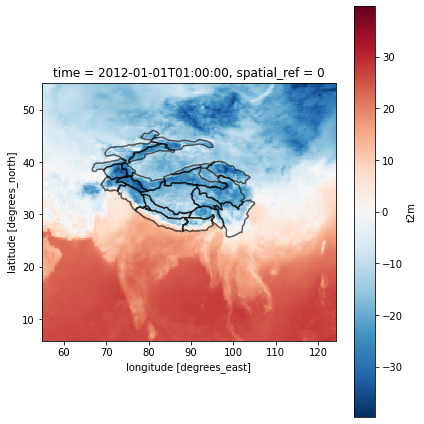

In [11]:
# plot all regions and climate data

fig, ax = plt.subplots(figsize=(6, 6))
climate.t2m[1,:,:].plot()#palette='viridis')
hma.boundary.plot(ax=ax, alpha=.6, color='black')
fig.tight_layout()

In [16]:
''' change name of the mountain range here'''

# roi = hma[hma['Name'] == 'Central Himalaya']
roi = hma[hma['Name'] == hma_df.Name[1]]
name = roi.Name
print(roi.Name)
# karakoram.crs

# add crs to the dataset (netcdf file) - maybe this is not even needed 
climate = climate.rio.write_crs('EPSG:4326')

# clip using xarrayrio library:
roi_climate = climate.rio.clip(roi.geometry, roi.crs, drop=True, invert=False)

1    Western Himalaya
Name: Name, dtype: object


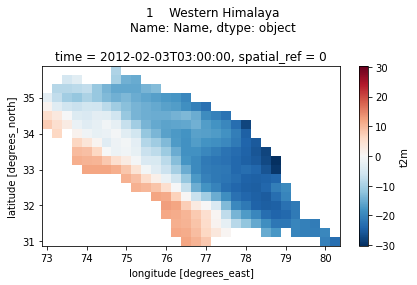

In [17]:
# see how it looks like 

roi_climate.t2m[795,:,:].plot()
plt.suptitle(str(name))
plt.tight_layout()

In [18]:
## convert to dataframe
roi_climate_df = roi_climate.to_dataframe() 
roi_climate_df = roi_climate_df.reset_index()

roi_climate_df = roi_climate_df.dropna()
roi_climate_df = roi_climate_df.drop_duplicates()


In [19]:
roi_climate_df.head()

,latitude,longitude,time,spatial_ref,ssrd,t2m,tcc,tp
61488,35.75,74.75,2012-01-01 00:00:00,0,0.000000,-18.936462,0.475989,0.011679
61489,35.75,74.75,2012-01-01 01:00:00,0,0.000000,-18.019287,0.568355,0.007432
61490,35.75,74.75,2012-01-01 02:00:00,0,0.000000,-17.402161,0.443975,0.005309
61491,35.75,74.75,2012-01-01 03:00:00,0,34.033401,-18.956573,0.387301,0.003189
61492,35.75,74.75,2012-01-01 04:00:00,0,201.336487,-18.695190,0.405063,0.002127


### how many era5 pixels there are? 

In [27]:
# calculate how many era5 pix fall into the mountain range polygon

x = roi_climate.t2m[1,:,:].values.flatten()
print('total numnber of pixels within bbox:', x.shape, '\n')

# without nans
x2 = x[~np.isnan(x)]
print('number of not-nan pixels:', x2.shape)

total numnber of pixels within bbox: (600,) 

number of not-nan pixels: (294,)


### plot ALL time-series of ALL pixels within region roi_climate_df

In [28]:
# roi_climate_df.columns
roi_climate_df.head()

,latitude,longitude,time,spatial_ref,ssrd,t2m,tcc,tp
61488,35.75,74.75,2012-01-01 00:00:00,0,0.000000,-18.936462,0.475989,0.011679
61489,35.75,74.75,2012-01-01 01:00:00,0,0.000000,-18.019287,0.568355,0.007432
61490,35.75,74.75,2012-01-01 02:00:00,0,0.000000,-17.402161,0.443975,0.005309
61491,35.75,74.75,2012-01-01 03:00:00,0,34.033401,-18.956573,0.387301,0.003189
61492,35.75,74.75,2012-01-01 04:00:00,0,201.336487,-18.695190,0.405063,0.002127


In [29]:
# (1) sub-select temperatures and precipitation separately: 
t2m = roi_climate_df[['latitude', 'longitude', 'time', 't2m']]
tp =  roi_climate_df[['latitude', 'longitude', 'time', 'tp']]
tcc =  roi_climate_df[['latitude', 'longitude', 'time', 'tcc']]
ssrd =  roi_climate_df[['latitude', 'longitude', 'time', 'ssrd']]




In [30]:
lats_and_lons = roi_climate_df[['latitude', 'longitude']].groupby(['latitude', 'longitude']).size().reset_index()
print('how many unique pairs of coordinates there are:', len(lats_and_lons))

how many unique pairs of coordinates there are: 294


Text(0.5, 0.98, '1    Western Himalaya\nName: Name, dtype: object')

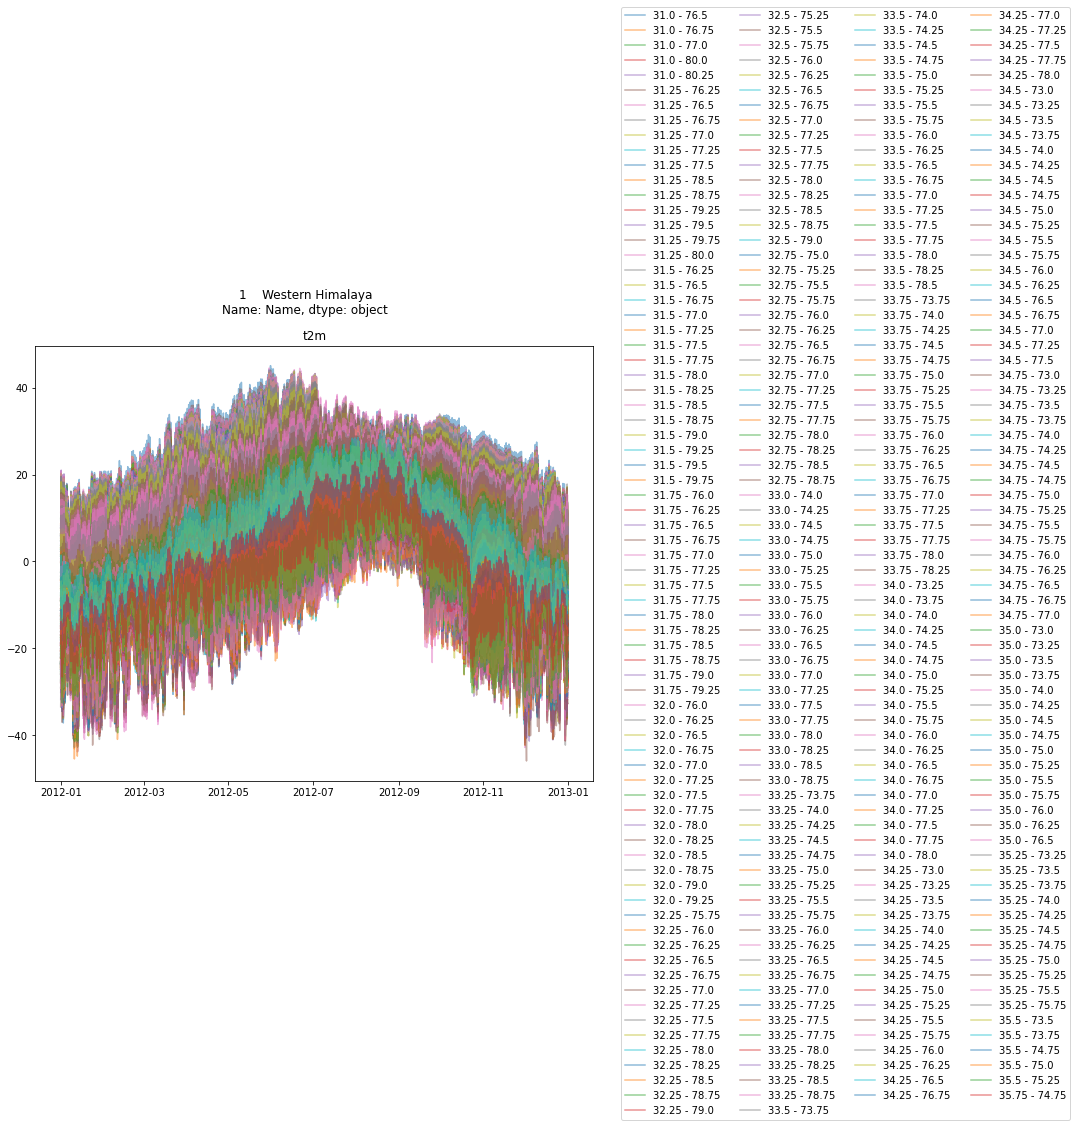

In [31]:
#  TEMPERATURES: 

fig, ax = plt.subplots(figsize=(10, 8))

# short = roi.reset_index()

subs_t2m = []

# for lat, lon in zip(roi.latitude, roi.longitude):

for lat, lon in zip(lats_and_lons.latitude, lats_and_lons.longitude):

# for lat, lon in zip(short.latitude.unique(), short.longitude.unique()):
    # print(lat, lon)
    subdf = t2m[(t2m.latitude==lat) & (t2m.longitude==lon)]
    subdf.set_index('time', inplace=True)
    
    subs_t2m.append(subdf)
    
    ax.plot(subdf.index, subdf.t2m, alpha = 0.5, label='{lat} - {lon}'.format(lat=lat, lon=lon))
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", ncol=4)
plt.title('t2m')
plt.suptitle(str(name))



Text(0.5, 0.98, '1    Western Himalaya\nName: Name, dtype: object')

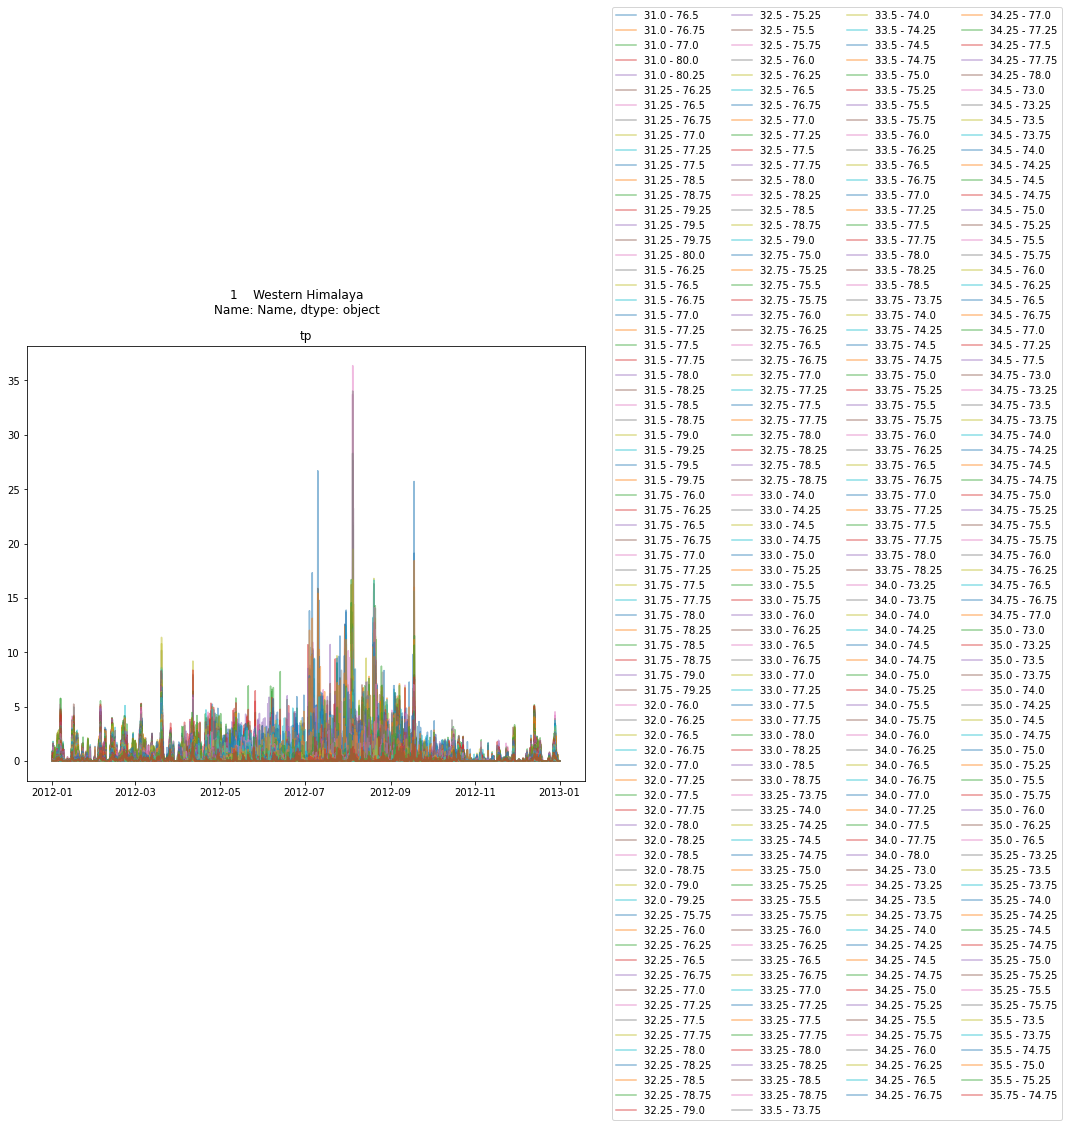

In [32]:
# TOTAL PRECIPITATION (HOURLY)

sub_tp = []

fig, ax = plt.subplots(figsize=(10, 8))

for lat, lon in zip(lats_and_lons.latitude, lats_and_lons.longitude):
    subdf = tp[(tp.latitude==lat) & (tp.longitude==lon)]
    subdf.set_index('time', inplace=True)
    
    sub_tp.append(subdf)
    
    ax.plot(subdf.index, subdf.tp, alpha = 0.5, label='{lat} - {lon}'.format(lat=lat, lon=lon))
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", ncol=4)
plt.title('tp')
plt.suptitle(str(name))



